## 1. Provinces of Argentina
<p><img style="float: left;margin:5px 20px 5px 1px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Buenos_Aires_Puerto_Madero_19.jpg/1200px-Buenos_Aires_Puerto_Madero_19.jpg" title="Photo by Andrzej Otrębski CC BY-SA 4.0"></p>
<p>With almost 40 million inhabitants and a diverse geography that encompasses the Andes mountains, glacial lakes, and the Pampas grasslands, Argentina is the second largest country (by area) and has one of the largest economies in South America. It is politically organized as a federation of 23 provinces and an autonomous city, Buenos Aires.</p>
<p>We will analyze ten economic and social indicators collected for each province. Because these indicators are highly correlated, we will use Principal Component Analysis (PCA) to reduce redundancies and highlight patterns that are not apparent in the raw data. After visualizing the patterns, we will use k-means clustering to partition the provinces into groups with similar development levels. </p>
<p>These results can be used to plan public policy by helping allocate resources to develop infrastructure, education, and welfare programs.</p>

In [163]:
# Load the tidyverse
# .... YOUR CODE FOR TASK 1 ....
library(tidyverse)
library(readr)

# Read in the dataset
argentina <- read_csv("datasets/argentina.csv")

# Inspect the first rows of the dataset
# .... YOUR CODE FOR TASK 1 ....
nrow(argentina)
# .... YOUR CODE FOR TASK 1 ....
head(argentina)

Parsed with column specification:
cols(
  province = col_character(),
  gdp = col_double(),
  illiteracy = col_double(),
  poverty = col_double(),
  deficient_infra = col_double(),
  school_dropout = col_double(),
  no_healthcare = col_double(),
  birth_mortal = col_double(),
  pop = col_double(),
  movie_theatres_per_cap = col_double(),
  doctors_per_cap = col_double()
)


[1] 22

province,gdp,illiteracy,poverty,deficient_infra,school_dropout,no_healthcare,birth_mortal,pop,movie_theatres_per_cap,doctors_per_cap
Buenos Aires,292689868,1.38324,8.167798,5.511856,0.7661682,48.7947,4.4,15625084,6.015968e-06,0.004835622
Catamarca,6150949,2.34414,9.234095,10.464484,0.9519631,45.0456,1.5,367828,5.437324e-06,0.004502104
C<U+00F3>rdoba,69363739,2.71414,5.382380,10.436086,1.0350558,45.7640,4.8,3308876,1.118204e-05,0.010175359
Corrientes,7968013,5.60242,12.747191,17.438858,3.8642652,62.1103,5.9,992595,4.029841e-06,0.004495288
Chaco,9832643,7.51758,15.862619,31.479527,2.5774621,65.5104,7.5,1055259,2.842904e-06,0.003604802
Chubut,17747854,1.54806,8.051752,8.044618,0.5863094,39.5473,3.0,509108,1.571376e-05,0.004498063


## 2. Most populous, richest provinces
<p>Argentina ranks third in South America in total population, but the population is unevenly distributed throughout the country. Sixty percent of the population resides in the Pampa region (Buenos Aires, La Pampa, Santa Fe, Entre Ríos and Córdoba) which only encompasses about 20% of the land area.</p>
<p><a href="https://en.wikipedia.org/wiki/Gross_domestic_product">GDP</a> is a measure of the size of a province's economy. To measure how rich or poor the inhabitants are, economists use <a href="https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita"><em>per capita GDP</em></a>, which is GDP divided by the province's population.</p>

In [165]:
# Add gdp_per_capita column to argentina
argentina <- argentina %>% 
  mutate(gdp_per_cap = gdp / pop) 

# Find the four richest provinces
(rich_provinces  <- argentina %>% 
# .... YOUR CODE FOR TASK 2 ....
 arrange(desc(gdp_per_cap)) %>%
 select(province, gdp_per_cap) %>%
 top_n(4)
 )
 
# Find the provinces with populations over 1 million
( bigger_pops <- argentina %>% 
# .... YOUR CODE FOR TASK 2 ....
 arrange(desc(pop))%>%
 select(province, pop)%>%
 filter(pop > 1000000)
 )

Selecting by gdp_per_cap


province,gdp_per_cap
Santa Cruz,42.57398
Neuqu<U+00E9>n,40.93143
Chubut,34.86069
San Luis,27.25093


province,pop
Buenos Aires,15625084
C<U+00F3>rdoba,3308876
Santa Fe,3194537
Mendoza,1738929
Tucum<U+00E1>n,1448188
Entre R<U+00ED>os,1235994
Salta,1214441
Misiones,1101593
Chaco,1055259


## 3. A matrix for PCA
<p>Principal Component Analysis (PCA) is an unsupervised learning technique that summarizes multivariate data by reducing redundancies (variables that are correlated). New variables (the principal components) are linear combinations of the original data that retain as much variation as possible. We would imagine that some aspects of economic and social data would be highly correlated, so let's see what pops out. But first, we need to do some data preparation.</p>
<p>R makes it easy to run a PCA with the <code>PCA()</code> function from the <code>FactoMineR</code> package. The first argument in <code>PCA()</code> is a data frame or matrix of the data where the rows are "individuals" (or in our case, provinces) and columns are numeric variables. To prepare for the analysis, we will remove the column of province names and build a matrix from the dataset.</p>

In [167]:
# Select numeric columns and cast to matrix
argentina_matrix  <- argentina  %>% 
  select_if(is.numeric) %>%  
  as.matrix()

# Print the first lines of the result
# .... YOUR CODE FOR TASK 3 ....
head(argentina_matrix)

gdp,illiteracy,poverty,deficient_infra,school_dropout,no_healthcare,birth_mortal,pop,movie_theatres_per_cap,doctors_per_cap,gdp_per_cap
292689868,1.38324,8.167798,5.511856,0.7661682,48.7947,4.4,15625084,6.015968e-06,0.004835622,18.732051
6150949,2.34414,9.234095,10.464484,0.9519631,45.0456,1.5,367828,5.437324e-06,0.004502104,16.722352
69363739,2.71414,5.382380,10.436086,1.0350558,45.7640,4.8,3308876,1.118204e-05,0.010175359,20.962931
7968013,5.60242,12.747191,17.438858,3.8642652,62.1103,5.9,992595,4.029841e-06,0.004495288,8.027456
9832643,7.51758,15.862619,31.479527,2.5774621,65.5104,7.5,1055259,2.842904e-06,0.003604802,9.317753
17747854,1.54806,8.051752,8.044618,0.5863094,39.5473,3.0,509108,1.571376e-05,0.004498063,34.860686


## 4. Reducing dimensions
<p>PCA finds a lower dimensional representation of the data that keeps the maximum amount of variance. It's great for analyzing multivariate datasets, like this one, with multiple numerical columns that are highly correlated. Typically, the first few components preserve most of the information in the raw data, allowing us, to go from eleven dimensions (eleven original variables) down to two dimensions (two variables that are summaries of the original eleven).</p>
<p>To run PCA, we need to make sure all the variables are on similar scales. Otherwise, variables with large variance will be overrepresented. In <code>PCA()</code> setting <code>scale.unit = TRUE</code> ensures that variables are scaled to unit variance before crunching the numbers.</p>
<p>Feel free to explore the output! </p>

In [169]:
# Load FactoMineR
# .... YOUR CODE FOR TASK 4 ....
library(FactoMineR)

# Apply PCA and print results
( argentina_pca  <- PCA(argentina_matrix, scale.unit = TRUE) )

**Results for the Principal Component Analysis (PCA)**
The analysis was performed on 22 individuals, described by 11 variables
*The results are available in the following objects:

   name               description                          
1  "$eig"             "eigenvalues"                        
2  "$var"             "results for the variables"          
3  "$var$coord"       "coord. for the variables"           
4  "$var$cor"         "correlations variables - dimensions"
5  "$var$cos2"        "cos2 for the variables"             
6  "$var$contrib"     "contributions of the variables"     
7  "$ind"             "results for the individuals"        
8  "$ind$coord"       "coord. for the individuals"         
9  "$ind$cos2"        "cos2 for the individuals"           
10 "$ind$contrib"     "contributions of the individuals"   
11 "$call"            "summary statistics"                 
12 "$call$centre"     "mean of the variables"              
13 "$call$ecart.type" "standard error o

## 5. PCA: Variables & Components
<p>Now that we have the principal components, we can see how the original variables are correlated among themselves and how the original variables are correlated with the principal components. We will build a plot using the <code>factoextra</code> package to help us understand these relationships. A correlation circle plot (also known as a variable correlation plot) shows the relationship among all variables as they are plotted on the first two principal components (Dimension 1 and Dimension 2).</p>
<p>To understand the plot, note that:</p>
<ul>
<li>Positively correlated variables have similar vectors.</li>
<li>The vectors of negatively correlated variables are on opposite sides of the plot origin (opposite quadrants).</li>
<li>Each axis represents a principal component. Vectors pointing in the direction of the component are correlated with that component.</li>
<li>The percentage of the original variance explained by each component (dimension) is given in parentheses in the axes labels.</li>
</ul>

In [171]:
print(colnames(argentina_pca$eig))

[1] "eigenvalue"                        "percentage of variance"           
[3] "cumulative percentage of variance"


[1] 63.54897

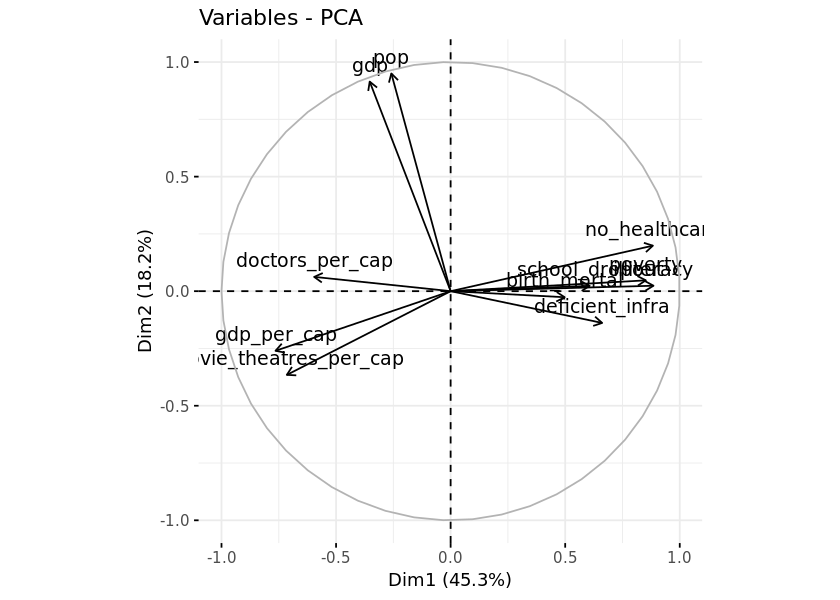

In [172]:
# Load factoextra
# .... YOUR CODE FOR TASK 5 ....
library(factoextra)

# Set the size of plots in this notebook
options(repr.plot.width=7, repr.plot.height=5)

# Plot the original variables and the first 2 components and print the plot object.
( pca_var_plot <- fviz_pca_var(argentina_pca) )

# Sum the variance preserved by the first two components. Print the result.
( variance_first_two_pca <- argentina_pca$eig[1, 2] + argentina_pca$eig[2, 2] )

## 6. Plotting the components
<p>With the first two principal components representing almost 65% of the variance, most of the information we are interested in is summarized in these two components. From the variable correlation plot, we can see that population and GDP are highly correlated; illiteracy, poverty, no healthcare, school dropout, and deficient infrastructure are correlated; and GDP per capita and movie theaters per capita are correlated.</p>
<p>But how do these correlations map to the provinces? To dive into that question, let's plot the individual principal components for each province and look for clusters.</p>

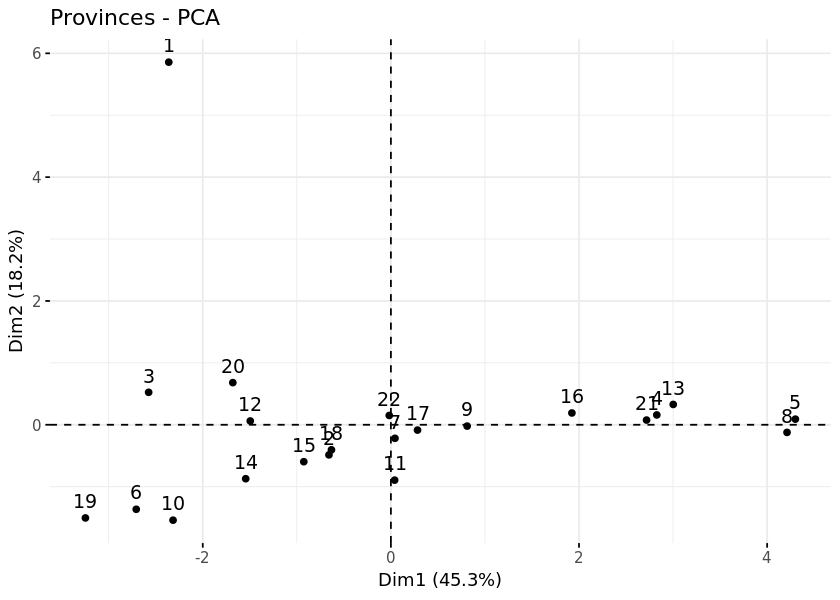

In [174]:
# Visualize Dim2 vs. Dim1
# .... YOUR CODE FOR TASK 6 ....
fviz_pca_ind(argentina_pca, title = "Provinces - PCA")

## 7. Cluster using K means
<p>It looks like one province stands out and the rest follow the gradient along the second dimension. Are there clusters we are not detecting? Let's use K-means clustering to see if there are patterns we are not detecting.</p>

In [176]:
argentina_pca$ind$coord

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
1,-2.36146994,5.85722972,0.02887238,1.1415873,-0.55664309
2,-0.65845451,-0.48651253,-1.29107656,-0.2415875,-0.03742897
3,-2.57528138,0.52381577,1.70307390,-0.9930687,2.11197740
4,2.82685473,0.15875925,0.48894162,-1.0256780,0.09720908
5,4.30008229,0.09073316,0.08145973,0.8101764,1.08427385
6,-2.70724552,-1.36535411,-0.23583031,0.9771357,-0.60816245
7,0.04335852,-0.21902507,-0.37815826,-0.1520217,0.62600102
8,4.21149482,-0.12335287,1.70641723,2.0281065,-0.06036068
9,0.81084392,-0.02185901,-1.40833132,0.3811242,-0.10375906
10,-2.31574880,-1.54147650,1.21560898,1.5886977,1.04580005


In [177]:
# Set seed to 1234 for reproducibility
# .... YOUR CODE FOR TASK 7 ....
set.seed(1234)

# Create an intermediate data frame with pca_1 and pca_2
argentina_comps <- tibble(pca_1 = argentina_pca$ind$coord[ ,1],  
                          pca_2 = argentina_pca$ind$coord[ ,2])

# Cluster the observations using the first 2 components and print its contents
( argentina_km <- kmeans(argentina_comps, centers = 4, nstart = 20, iter.max = 50) )

K-means clustering with 4 clusters of sizes 1, 7, 6, 8

Cluster means:
       pca_1      pca_2
1 -2.3614699  5.8572297
2 -2.2235295 -0.5740342
3  3.1637648  0.1200775
4 -0.1320515 -0.3199319

Clustering vector:
 [1] 1 4 2 3 3 2 4 3 4 2 4 2 3 2 4 3 4 4 2 2 3 4

Within cluster sum of squares by cluster:
[1] 0.000000 8.403846 4.375350 3.109136
 (between_SS / total_SS =  89.7 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

## 8. Components with colors
<p>Now that we have cluster assignments for each province, we will plot the provinces according to their principal components coordinates, colored by the cluster.</p>

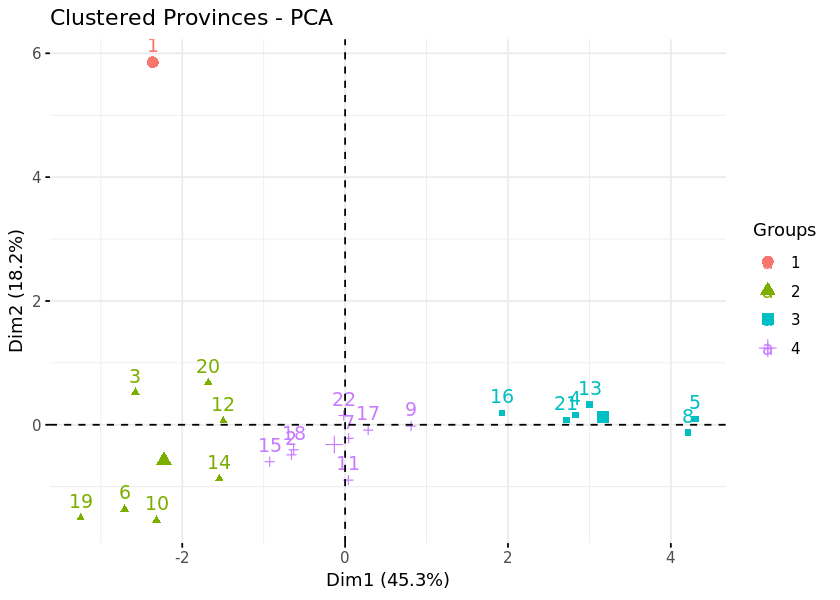

In [179]:
# Convert assigned clusters to factor
# .... YOUR CODE FOR TASK 8 ....
clusters_as_factor = factor(argentina_km$cluster)

# Plot individulas colored by cluster
fviz_pca_ind(argentina_pca, 
             title = "Clustered Provinces - PCA", 
             habillage = clusters_as_factor) 

## 9. Buenos Aires, in a league of its own
<p>A few things to note from the scatter plot:</p>
<ul>
<li>Cluster 1 includes only Buenos Aires and has a large positive value in Dimension 2 with an intermediate negative value in Dimension 1.</li>
<li>Cluster 2 has the greatest negative values in Dimension 1.</li>
<li>Cluster 3 has the greatest positive values in Dimension 1.</li>
<li>Cluster 4 has small absolute values in Dimension 1.</li>
<li>Clusters 2, 3, and 4, all have small absolute values in Dimension 2.</li>
</ul>
<p>We will focus on exploring clusters 1, 2, and 3 in terms of the original variables in the next few tasks.</p>
<p>As we noted earlier, Buenos Aires is in a league of its own, with the largest positive value in Dimension 2 by far. The figure below is a biplot, a combination of the individuals plot from Task 6 and the circle plot from Task 5.</p>
<p><img width="700px" height="700px" src="https://assets.datacamp.com/production/project_638/img/biplot.png"></p>
<p>Since the vectors corresponding to <code>gdp</code> and <code>pop</code> are in the same direction as Dimension 2, Buenos Aires has high GDP and high population. Let's visualize this pattern with a plot of <code>gdp</code> against <code>cluster</code> (we should get similar results with <code>pop</code>).</p>

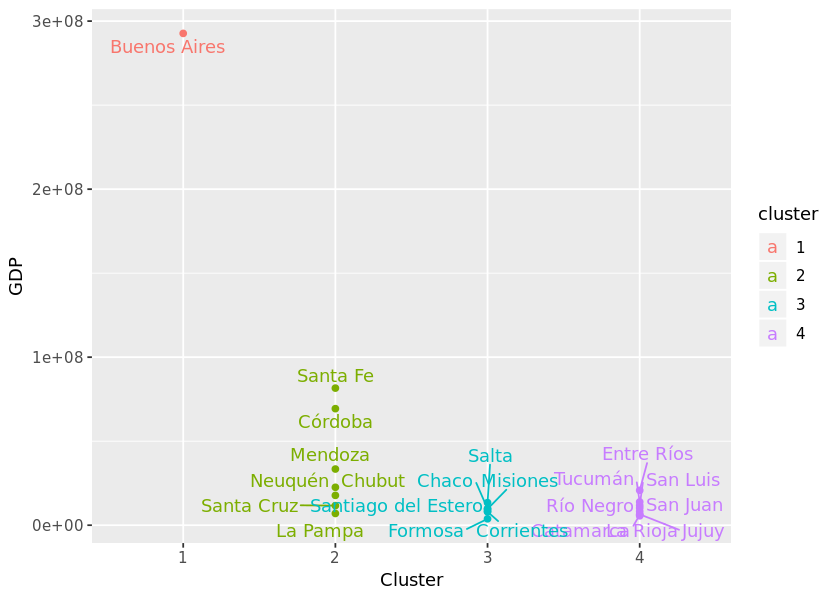

In [181]:
# Load ggrepel
# .... YOUR CODE FOR TASK 9 ....
library(ggrepel)

# Add cluster column to argentina
argentina <- argentina %>%
               mutate(cluster=clusters_as_factor)

# Make a scatterplot of gdp vs. cluster, colored by cluster
ggplot(argentina, aes(cluster, gdp, color = cluster, label = province)) +
  # .... YOUR CODE FOR TASK 9 ....
  geom_point(show.legend = FALSE) +
  labs(x = "Cluster", y = "GDP") + geom_text_repel()

## 10. The rich provinces
<p>Provinces in cluster 2 have large negative values in Dimension 1. The biplot shows that <code>gdp_per_cap</code>, <code>movie_theaters_per_cap</code> and <code>doctors_per_cap</code> also have high negative values in Dimension 1. </p>
<p><img width="700px" height="700px" src="https://assets.datacamp.com/production/project_638/img/biplot.png"></p>
<p>If we plot <code>gdp_per_cap</code> for each cluster, we can see that provinces in this cluster 2, in general, have greater GDP per capita than the provinces in the other clusters. San Luis is the only province from the other clusters with <code>gdp_per_cap</code> in the range of values observed in cluster 2. We will see similar results for <code>movie_theaters_per_cap</code> and <code>doctors_per_cap</code>.</p>

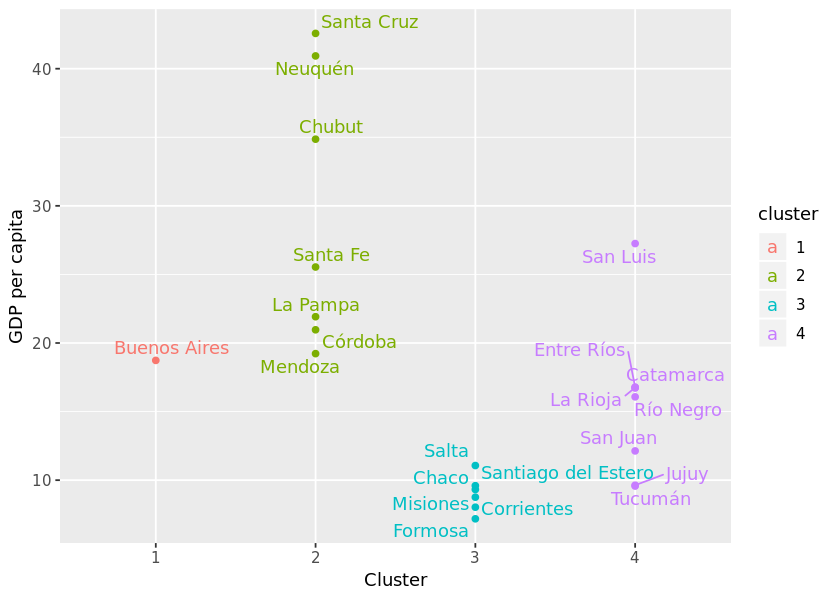

In [183]:
# Make a scatterplot of GDP per capita vs. cluster, colored by cluster
ggplot(argentina, aes(cluster, gdp_per_cap, color = cluster, label = province)) +
  # .... YOUR CODE FOR TASK 10 ....
  geom_point(show.legend = FALSE) +
  labs(x = "Cluster", y = "GDP per capita") + geom_text_repel()

## 11. The poor provinces
<p>Provinces in Cluster 3 have high positive values in Dimension 1. As shown in the biplot, provinces with high positive values in Dimension 1 have high values in poverty, deficient infrastructure, etc. These variables are also negatively correlated with <code>gdp_per_cap</code>, so these provinces have low values in this variable.</p>
<p><img width="700px" height="700px" src="https://assets.datacamp.com/production/project_638/img/biplot.png"></p>

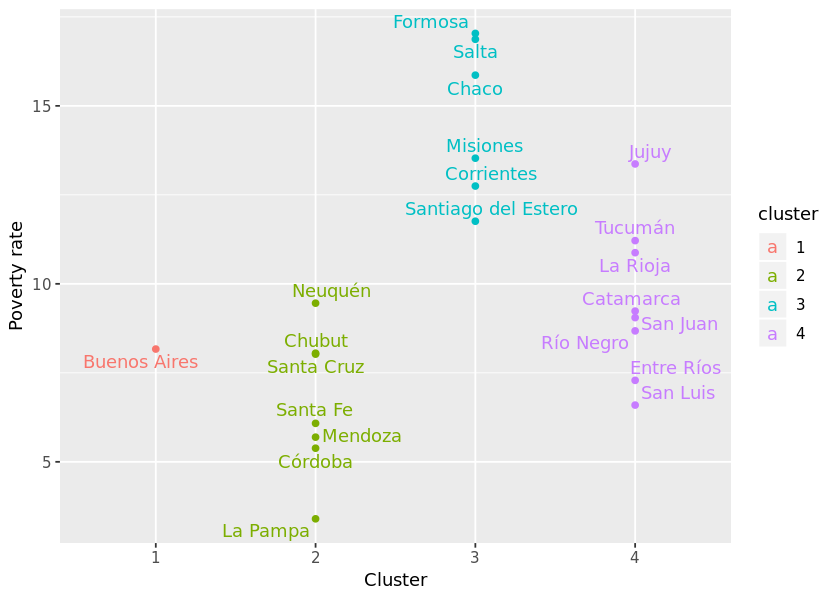

In [185]:
# Make scatterplot of poverty vs. cluster, colored by cluster
ggplot(argentina, aes(cluster, poverty, color = cluster, label = province)) +
  # .... YOUR CODE FOR TASK 11 ....
  labs(x = "Cluster", y = "Poverty rate") +
  geom_point(show.legend = FALSE) + geom_text_repel()

## 12. Planning for public policy
<p>Now that we have an idea of how social and economic welfare varies among provinces, we've been asked to help plan an education program. A pilot phase of the program will be carried out to identify design issues. Our goal is to select the proposal with the most diverse set of provinces:</p>
<ol>
<li>Tucumán, San Juán, and Entre Ríos</li>
<li>Córdoba, Santa Fé, and Mendoza</li>
<li>Buenos Aires, Santa Cruz, and Misiones </li>
</ol>
<p>Which proposal includes the most diverse set of provinces?</p>
<p><img width="800px" height="800px" src="https://assets.datacamp.com/production/project_638/img/components_color.png"></p>

In [187]:
# Assign pilot provinces to the most diverse group
pilot_provinces <- 3